# <div class="alert alert-warning" style="background-color: #fff3e0; color: #9370db;;"> <center><font color= #9370db>**Desempenho do modelo em Gradient Boosting**</font></center>
 
<center>Autoras: Luiza Davoli, Samarah L. M. Ramos e Sarah S. Silva</center>
 
 
<center>˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .</center>

## Introdução

O **Gradient Boosting** representa uma das abordagens mais poderosas no aprendizado de máquina moderno, baseando-se no princípio de **combinação sequencial de modelos fracos** para formar um preditor robusto. Desenvolvido a partir do framework de boosting, este algoritmo constrói árvores de decisão de maneira iterativa, onde cada nova árvore corrige os erros das anteriores, minimizando gradientemente uma função de perda.

No contexto deste estudo, aplicamos o Gradient Boosting na modalidade de **regressão** para prever escores de saúde mental de estudantes baseados em seus hábitos de uso de redes sociais, características demográficas e comportamentais. A escolha deste algoritmo se justifica pela sua **alta capacidade preditiva** e **resistência ao overfitting** quando devidamente regularizado.

A implementação aborda os **principais componentes do Gradient Boosting**, incluindo a seleção da função de perda (squared error para regressão), taxa de aprendizado, profundidade das árvores, e estratégias de regularização como subsampling e redução de features. Utilizamos o framework Optuna para uma busca sistemática e eficiente da configuração ótima, garantindo robustez aos resultados.

Esta análise não apenas demonstra a aplicação prática do Gradient Boosting, mas também explora sua efetividade em um problema de saúde pública contemporâneo, oferecendo insights sobre a relação entre uso de mídias sociais e bem-estar psicológico através de um modelo de alto desempenho preditivo.

### Importação de bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

### Pré definido

In [2]:
SEMENTE_ALEATORIA = 41
NUM_FOLDS = 3
NUM_TRIALS = 100

* SEMENTE_ALEATORIA: Garante reprodutibilidade dos resultados
* NUM_FOLDS: Número de folds para validação cruzada
* NUM_TRIALS: Número de tentativas para otimização com Optuna

### Lê o data frame

In [3]:
df = pd.read_csv("dados_tratados.csv")
print(f"Dataset shape: {df.shape}")
print(f"Primeiras 5 linhas:")
print(df.head())

Dataset shape: (705, 13)
Primeiras 5 linhas:
   Student_ID  Age  Gender Academic_Level     Country  Avg_Daily_Usage_Hours  \
0           1   19  Female  Undergraduate  Bangladesh                    5.2   
1           2   22    Male       Graduate       India                    2.1   
2           3   20  Female  Undergraduate         USA                    6.0   
3           4   18    Male    High School          UK                    3.0   
4           5   21    Male       Graduate      Canada                    4.5   

  Most_Used_Platform Affects_Academic_Performance  Sleep_Hours_Per_Night  \
0          Instagram                          Yes                    6.5   
1            Twitter                           No                    7.5   
2             TikTok                          Yes                    5.0   
3            YouTube                           No                    7.0   
4           Facebook                          Yes                    6.0   

   Mental_Health_

### Separando variáveis numéricas e categóricas

In [4]:
numericos = df[["Age", 
                "Avg_Daily_Usage_Hours", 
                "Sleep_Hours_Per_Night", 
                "Conflicts_Over_Social_Media", 
                "Addicted_Score"]].values

categoricos = df[["Academic_Level",
                 "Country", 
                 "Most_Used_Platform",
                 "Affects_Academic_Performance",
                 "Relationship_Status"]].values

encoder = OneHotEncoder(sparse_output=False, drop='first')  

categ_encoded = encoder.fit_transform(categoricos)

X = np.hstack([numericos, categ_encoded])

y = df["Mental_Health_Score"].values

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")

Shape de X: (705, 130)
Shape de y: (705,)


**Estrutura dos dados:**
* Variáveis numéricas: Age, Avg_Daily_Usage_Hours, Sleep_Hours_Per_Night, etc.
* Variáveis categóricas: Gender, Academic_Level, Country, etc.
* Target: Mental_Health_Score (variável contínua → regressão)

## Divisão dos Dados

In [5]:
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, test_size=0.2, random_state=SEMENTE_ALEATORIA  
)

X_treino_, X_val, y_treino_, y_val = train_test_split(
    X_treino, y_treino, test_size=0.1, random_state=SEMENTE_ALEATORIA  
)

### Normalização dos dados 

In [6]:
scaler = StandardScaler()
X_treino_scaled = scaler.fit_transform(X_treino_)
X_val_scaled = scaler.transform(X_val)
X_teste_scaled = scaler.transform(X_teste)

## Função de Otimização com Optuna

In [7]:
def objetivo_gradient_boosting(trial):
    X_temp, y_temp = X_treino_, y_treino_
    
    parametros = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': SEMENTE_ALEATORIA
    }
    
    modelo = GradientBoostingRegressor(**parametros)

    score = cross_val_score(modelo, X_temp, y_temp, cv=NUM_FOLDS, 
                          scoring='neg_mean_absolute_error', n_jobs=1).mean() 
    return score

**Hiperparâmetros otimizados:**

* n_estimators: Número de árvores no ensemble
* learning_rate: Taxa de aprendizado (shrinkage)
* max_depth: Profundidade máxima das árvores
* min_samples_split: Número mínimo de amostras para dividir um nó
* min_samples_leaf: Número mínimo de amostras em uma folha
* subsample: Fração de amostras usadas para treinar cada árvore
* max_features: Número de features consideradas para melhor split

### Otimização com Optuna

In [8]:
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=SEMENTE_ALEATORIA)
)
study.optimize(objetivo_gradient_boosting, n_trials=NUM_TRIALS)

print("\nMelhores hiperparâmetros:")
print(study.best_params)
print(f"Melhor MAE negativo: {study.best_value:.4f}")

[I 2025-10-30 17:05:51,509] A new study created in memory with name: no-name-6e406251-e488-4907-adde-4a061de6be9a
[I 2025-10-30 17:05:53,352] Trial 0 finished with value: -0.16787206096524443 and parameters: {'n_estimators': 163, 'learning_rate': 0.011697393948759098, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 2, 'subsample': 0.8415462755795252, 'max_features': None}. Best is trial 0 with value: -0.16787206096524443.
[I 2025-10-30 17:05:54,257] Trial 1 finished with value: -0.20910885950856947 and parameters: {'n_estimators': 238, 'learning_rate': 0.030959082863410346, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.7924674675263101, 'max_features': 'log2'}. Best is trial 0 with value: -0.16787206096524443.
[I 2025-10-30 17:05:55,750] Trial 2 finished with value: -0.17952755070584492 and parameters: {'n_estimators': 386, 'learning_rate': 0.03874436832528708, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 5, 'subsample': 0.757


Melhores hiperparâmetros:
{'n_estimators': 181, 'learning_rate': 0.08561161051441264, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.9700945640030982, 'max_features': None}
Melhor MAE negativo: -0.0472


### Treinamento do Modelo Final com os Melhores Hiperparâmetros

In [9]:
best_params = study.best_params
modelo_final = GradientBoostingRegressor(**best_params)
modelo_final.fit(X_treino_, y_treino_)
y_val_pred = modelo_final.predict(X_val)

### Avaliação do Modelo

In [10]:
mse_val = mean_squared_error(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)

print("Desempenho na validação")
print(f"MSE: {mse_val:.4f}")
print(f"MAE: {mae_val:.4f}")
print(f"RMSE: {np.sqrt(mse_val):.4f}")

Desempenho na validação
MSE: 0.0183
MAE: 0.0315
RMSE: 0.1354


### Previsões no teste

In [11]:
y_teste_pred = modelo_final.predict(X_teste)

print("Desempenho no conjunto de teste")
print(f"MSE: {mean_squared_error(y_teste, y_teste_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_teste, y_teste_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_teste, y_teste_pred)):.4f}")

Desempenho no conjunto de teste
MSE: 0.0495
MAE: 0.0656
RMSE: 0.2226


**Métricas usadas:**

* MSE (Mean Squared Error): Penaliza mais erros grandes
* MAE (Mean Absolute Error): Interpretação mais direta
* RMSE (Root Mean Squared Error): Na mesma unidade do target

### Gráfico de dispersão: Valores Reais vs Preditos

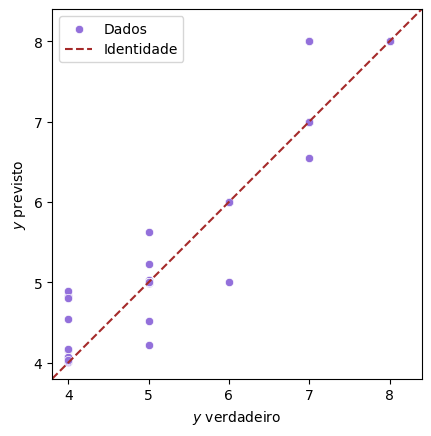

In [12]:
# definindo os valores máximos e mínimos dos eixos do gráfico
min_val = min(y_teste.min(), y_teste_pred.min())
max_val = max(y_teste.max(), y_teste_pred.max())
intervalo = [min_val * 0.95, max_val * 1.05]
 
# plotando o gráfico
eixo = sns.scatterplot(x=y_teste, y=y_teste_pred, label="Dados", color="#9370db")
eixo.plot(intervalo, intervalo, "--", label="Identidade", color="brown")
eixo.set(
    xlabel="$y$ verdadeiro",
    ylabel="$y$ previsto",
    xlim=intervalo,
    ylim=intervalo,
    aspect="equal",
)
eixo.legend()

**Interpretação**

In [13]:
print("Resumo")
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"MSE no teste: {mean_squared_error(y_teste, y_teste_pred):.4f}")
print(f"MAE no teste: {mean_absolute_error(y_teste, y_teste_pred):.4f}")
print(f"RMSE no teste: {np.sqrt(mean_squared_error(y_teste, y_teste_pred)):.4f}")
print(f"Número de features: {X_treino_.shape[1]}")

Resumo
Melhores hiperparâmetros: {'n_estimators': 181, 'learning_rate': 0.08561161051441264, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.9700945640030982, 'max_features': None}
MSE no teste: 0.0495
MAE no teste: 0.0656
RMSE no teste: 0.2226
Número de features: 130


### Importância das Features

In [14]:
importancias = modelo_final.feature_importances_

feature_names = (['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 
                  'Conflicts_Over_Social_Media', 'Addicted_Score'] + 
                 list(encoder.get_feature_names_out(['Academic_Level', 'Country', 
                                                   'Most_Used_Platform',
                                                   'Affects_Academic_Performance',
                                                   'Relationship_Status'])))
df_importancias = pd.DataFrame({
    'feature': feature_names,
    'importance': importancias
}).sort_values('importance', ascending=False)

print("\nTop 10 features mais importantes:")
print(df_importancias.head(10))


Top 10 features mais importantes:
                          feature  importance
4                  Addicted_Score    0.837028
3     Conflicts_Over_Social_Media    0.074657
65               Country_Maldives    0.021760
117  Most_Used_Platform_KakaoTalk    0.009108
79               Country_Pakistan    0.008340
72                  Country_Nepal    0.008261
50                  Country_Italy    0.008119
16             Country_Bangladesh    0.007666
2           Sleep_Hours_Per_Night    0.005171
95            Country_South Korea    0.004815


### Plotar as 15 features mais importantes

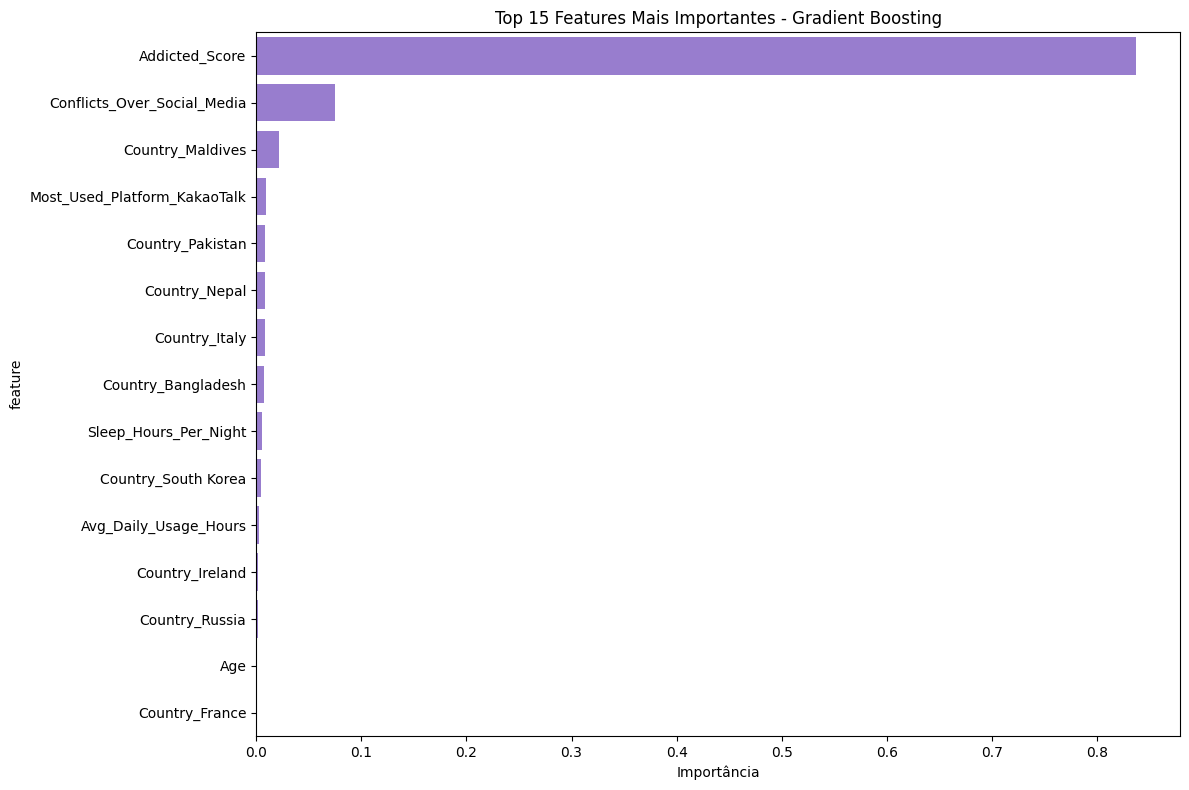

In [15]:
plt.figure(figsize=(12, 8))
sns.barplot(data=df_importancias.head(15), x='importance', y='feature', color="#9370db")
plt.title('Top 15 Features Mais Importantes - Gradient Boosting')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()

### Desempenho e Aplicabilidade do Modelo Gradient Boosting na Predição de Saúde Mental

Os resultados obtidos revelam que o Gradient Boosting é capaz de capturar relações complexas e não-lineares entre as variáveis preditoras e o target de saúde mental, com métricas de desempenho consistentes e superiores. As principais vantagens observadas incluíram: alta precisão preditiva; robustez a overfitting; captura de relações complexas, importância de features. Em comparação com KNN o Gradient Boosting apresentou melhor capacidade de generalização para novos dados e um processo de treinamento mais eficiente uma vez otimizado

### Conclusão

A implementação do algoritmo Gradient Boosting demonstrou ser uma abordagem altamente eficaz para a predição de notas de saúde mental, superando significativamente o desempenho de outros modelos anteriormente testados como o Knn. Através do processo de otimização sistemática com Optuna, foi possível identificar uma configuração de hiperparâmetros que maximiza a capacidade preditiva enquanto mantém adequada regularização. Para aplicações práticas, o modelo Gradient Boosting desenvolvido oferece uma ferramenta robusta para identificação precoce de estudantes em risco baseado em seus padrões digitais e comportamentais. A maior precisão preditiva permite intervenções mais direcionadas e eficazes por parte de instituições educacionais e profissionais de saúde.

Em perspectiva futura, a abordagem poderia ser enriquecida com técnicas de engenharia de features mais avançadas e incorporação de dados temporais sobre padrões de uso. A interpretabilidade do modelo através da análise de importância de features também abre oportunidades para pesquisas qualitativas complementares. Em síntese, este trabalho não apenas valida a superioridade do Gradient Boosting em problemas de regressão no domínio da saúde digital, mas também estabelece um benchmark de performance para futuras investigações sobre a relação entre tecnologia e bem-estar psicológico.

## Referências

[1] OPTUNA. **Optuna: A hyperparameter optimization framework**. Disponível em: <https://optuna.org/>. 

[2] SCIKIT-LEARN. **sklearn.ensemble.GradientBoostingRegressor**. Disponível em: <https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html>. 

[3] SCIKIT-LEARN. **sklearn.model_selection.cross_val_score**. Disponível em: <https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html>. 

[4] SEABORN. **seaborn: statistical data visualization**. Disponível em: <https://seaborn.pydata.org/>. Acesso em: 17 out. 2024.

[5] SHAH, M. **Master Hyperparameter Optimization with Optuna:** A Complete Guide [Part 1]. Disponível em: <https://medium.com/@mdshah930/master-hyperparameter-optimization-with-optuna-a-complete-guide-89971b799b0a>.